In [1]:
using Pkg
Pkg.activate(pwd())
Pkg.instantiate()
Pkg.develop("QuantumDots")
Pkg.add("DifferentialEquations")
using QuantumDots, QuantumDots.BlockDiagonals, LinearAlgebra
using Plots
using DifferentialEquations

  Activating project at `c:\Users\svens\.julia\dev\QuantumDots\examples`


   Resolving package versions...


  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Manifest.toml`


   Resolving package versions...


  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Project.toml`
  No Changes to `C:\Users\svens\.julia\dev\QuantumDots\examples\Manifest.toml`


In [2]:
struct MajoranaWrapper{B,D}
    basis::B
    majoranas::D
    function MajoranaWrapper(basis, labels=collect(Base.product(keys(basis), (:a, :b))))
        N = length(basis)
        length(labels) == 2 * N || throw(ErrorException("Number of majoranas is not twice the fermion number"))
        majA = map(f -> f + f', basis)
        majB = map(f -> 1im * (f - f'), basis)
        majs = vcat(majA, majB)
        dA = QuantumDots.dictionary(zip(labels[1:N], values(majA)))
        dB = QuantumDots.dictionary(zip(labels[N+1:2N], values(majB)))
        d = merge(dA, dB)
        new{typeof(basis),typeof(d)}(basis, d)
    end
end
Base.getindex(g::MajoranaWrapper, i...) = g.majoranas[i...]

In [3]:
c = FermionBasis(1:2)
γ = MajoranaWrapper(c, 0:3)

MajoranaWrapper{FermionBasis{2, Int64, SparseArrays.SparseMatrixCSC{Int64, Int64}, QuantumDots.NoSymmetry}, Dictionaries.Dictionary{Int64, SparseArrays.SparseMatrixCSC{T, Int64} where T}}(FermionBasis{2,Int64,SparseArrays.SparseMatrixCSC{Int64, Int64},QuantumDots.NoSymmetry}:
keys = {1, 2}, {0 = sparse([2, 1, 4, 3], [1, 2, 3, 4], [1, 1, -1, -1], 4, 4), 1 = sparse([3, 4, 1, 2], [1, 2, 3, 4], [1, 1, 1, 1], 4, 4), 2 = sparse([2, 1, 4, 3], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 + 1im, 0 + 1im, 0 - 1im], 4, 4), 3 = sparse([3, 4, 1, 2], [1, 2, 3, 4], Complex{Int64}[0 - 1im, 0 - 1im, 0 + 1im, 0 + 1im], 4, 4)})

In [164]:
smooth_step(x, k) = 1 / 2 + tanh(k * x) / 2
# Give the value of the three deltas at time t in the three point majorana braiding protocol
function braiding_deltas(t, T, Δmax, Δmin, k, args...)
    Δ1 = Δtrajectory(t, T, Δmax, Δmin, k)
    Δ2 = Δtrajectory(t + T / 3, T, Δmax, Δmin, k)
    Δ3 = Δtrajectory(t + 2T / 3, T, Δmax, Δmin, k)
    return Δ1, Δ2, Δ3
end
function Δtrajectory(t, T, Δmax, Δmin, k, args...)
    dΔ = Δmax - Δmin
    tp = mod(t, T) - T / 12
    Δmin + dΔ * smooth_step(tp - 1T / 6, k) - dΔ * smooth_step(tp - 4T / 6, k)
end

Δtrajectory (generic function with 2 methods)

(101, 3)


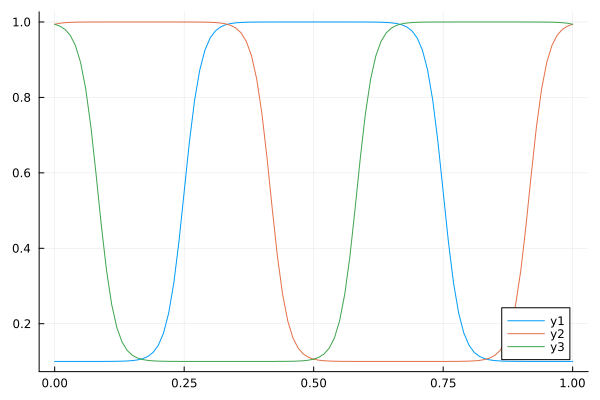

In [165]:
let T = 1, Δmax = 1, Δmin = 0.1, k = 30
    ts =  0:0.01:T
    deltas = stack([braiding_deltas(t, T, Δmax, Δmin, k) for t in ts])'
    println(size(deltas))
    plot(ts,deltas)
end

In [166]:
const γ01 = Matrix(1.0im*γ[0]*γ[1])
const γ02 = Matrix(1.0im*γ[0]*γ[2])
const γ03 = Matrix(1.0im*γ[0]*γ[3])
H(t, (T,Δmin, Δmax, k,σ)) = H(t, (T,Δmin, Δmax, k))
function H(t, (T,Δmin, Δmax, k))
    Δ1, Δ2, Δ3 = braiding_deltas(t, T, Δmax, Δmin, k)
    Δ1 * γ01 + Δ2 * γ02 + Δ3 * γ03
end

H (generic function with 1 method)

In [297]:
function g(du, uv, (T, Δmin, Δmax, k, σ), t)
    u = reshape(uv, size(γ01))
    du[:, 1] .= 1im .* σ .* vec(γ01 * u - u * γ01)
    du[:, 2] .= 1im .* σ .* vec(γ02 * u - u * γ02)
    du[:, 3] .= 1im .* σ .* vec(γ03 * u - u * γ03)
end

g (generic function with 1 method)

In [298]:
_du = zeros(ComplexF64, length(γ01),3)
g(_du, rand(ComplexF64,4,4), (1, 0.1, 10, 50,1.0im), .2);
[tr(reshape(_du[:,n],4,4)) for n in 1:3]

3-element Vector{ComplexF64}:
 1.1102230246251565e-16 - 2.220446049250313e-16im
                    0.0 + 0.0im
                    0.0 + 0.0im

In [299]:
function schrödinger!(du, u, p, t)
    ham = 1im .* H(t, p)
    mul!(du, ham, u)
    return du
end
function heisenberg!(du, u, p, t)
    ham = H(t, p)
    heisenberg!(du, u, p, t, ham)
end
function heisenberg!(du, u, p, t, ham)
    du .= 1im .* (ham * u .- u * ham)
    return du
end
function heisenbergvec!(duv, uv, p, t)
    u = reshape(uv, size(γ01))
    du = reshape(duv, size(γ01))
    ham = H(t, p)
    # heisenberg!(du, u, p, t)
    duv .= 1im .* vec(ham * u .- u * ham)
    return duv
end

heisenbergvec! (generic function with 1 method)

In [483]:
u0 = 1.0complex(Matrix(γ[1]))
T = 0.1
k = 100 / T
Δmax = 1e2 / T
Δmin = Δmax * 1e-2
σ = .5
p = (T, Δmin, Δmax, k, σ)
tspan = (0.0, 2T)
prob = ODEProblem(heisenberg!, u0, tspan, p)
W = RealWienerProcess(0.0, zeros(3), zeros(3))
sdeprob = SDEProblem(heisenbergvec!, g, deepcopy(vec(u0)), tspan, p,
    noise_rate_prototype=zeros(ComplexF64, length(γ01), 3),
    noise=W)

# sdeprob = SDEProblem(foo,foog, deepcopy(vec(u0)), tspan, p,
#noise_rate_prototype=zeros(ComplexF64, length(γ01), 1),
#noise=RealWienerProcess(0.0, [0.0], [0.0]))

# sdeprob = ODEProblem(heisenbergvec!, deepcopy(vec(u0)), tspan, p,)
ts = range(0, tspan[2], 300)
deltas = stack([braiding_deltas(t, p...) for t in ts])'
plot(ts, deltas);

In [484]:
@time sol = solve(prob, saveat=ts)
# @time sdesol = solve(sdeprob, RKMilCommute(), saveat = ts)
@time sdesol = solve(sdeprob, ImplicitEulerHeun(symplectic=true, theta=1 / 2, autodiff=false),
    saveat=ts, abstol=1e-4, reltol=1e-6)
# @time sdesol = solve(sdeprob; saveat=ts)#, ImplicitEM(autodiff=false), saveat = ts)

  0.006105 seconds (33.29 k allocations: 10.669 MiB)


  0.858867 seconds (3.80 M allocations: 674.054 MiB, 30.73% gc time)


retcode: Success
Interpolation: 1st order linear
t: 300-element Vector{Float64}:
 0.0
 0.0006688963210702341
 0.0013377926421404682
 0.002006688963210702
 0.0026755852842809363
 0.0033444816053511705
 0.004013377926421404
 0.0046822742474916385
 0.005351170568561873
 0.006020066889632107
 ⋮
 0.19464882943143813
 0.19531772575250836
 0.1959866220735786
 0.19665551839464884
 0.19732441471571907
 0.1979933110367893
 0.19866220735785953
 0.19933110367892976
 0.2
u: 300-element Vector{Vector{ComplexF64}}:
 [0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im]
 [0.0 + 0.0im, -0.005908604673672434 + 0.03194691149371271im, 0.9989525071193616 + 0.032248638994765426im, 0.0 + 0.0im, -0.005908604673672434 - 0.03194691149371271im, 0.0 + 0.0im, 0.0 + 0.0im, 0.9989525071193616 + 0.032248638994765426im, 0.9989525071193616 - 0.032248638994765426im, 0

In [485]:
projs = stack([[abs(tr(γ * sol(t))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';
sdeprojs = stack([[abs(tr(γ * reshape(sdesol(t), size(γ)))) for γ in (γ[1], γ[2], γ[3])] for t in ts])';

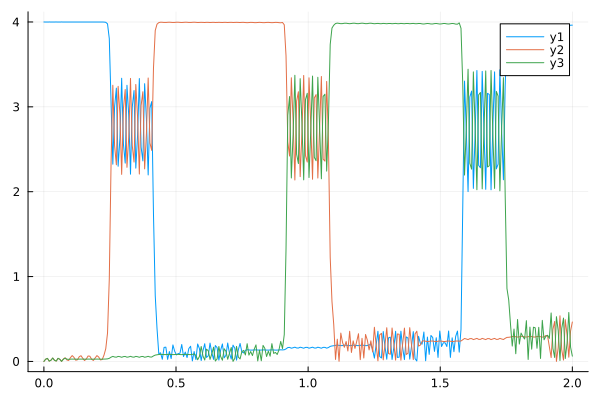

In [486]:
plot(ts ./ T, projs)

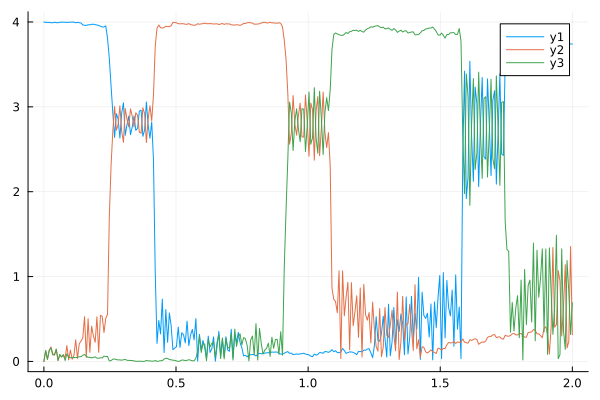

In [487]:
plot(ts ./ T, sdeprojs)

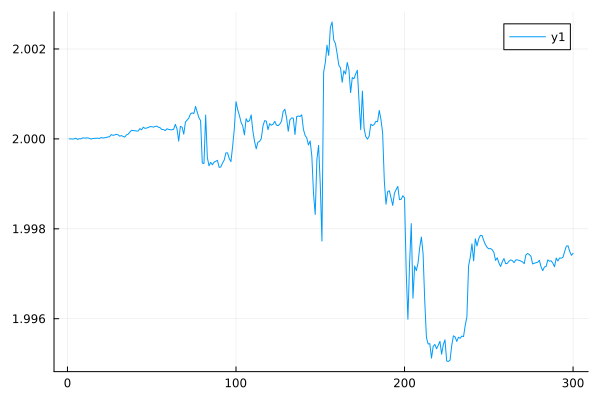

In [488]:
plot(map(norm, sdesol))

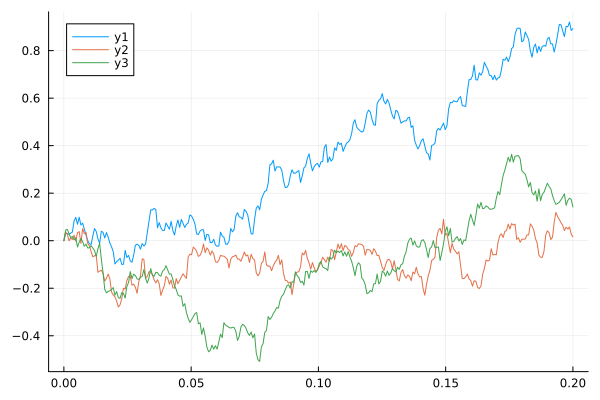

In [489]:
plot(ts,stack(first.(sdeprob.noise.(ts)))')

In [491]:
function prob_func(prob, i, repeat)
    W = RealWienerProcess(0.0, zeros(3), zeros(3))
    remake(prob; noise=W)
end
ensembleprob = EnsembleProblem(sdeprob; 
#prob_func,
    output_func = (sol, i) -> (map(s->push!([abs(tr(γ*reshape(s,size(γ)))) for γ in (γ[1],γ[2],γ[3])], norm(s)), sol), false),)

EnsembleProblem with problem SDEProblem

In [492]:
enssol = solve(ensembleprob,ImplicitEulerHeun(symplectic=true, theta=1 / 2, autodiff=false), EnsembleThreads(),
     trajectories = 100, saveat=ts, abstol=1e-4, reltol=1e-6)

EnsembleSolution Solution of length 100 with uType:
Vector

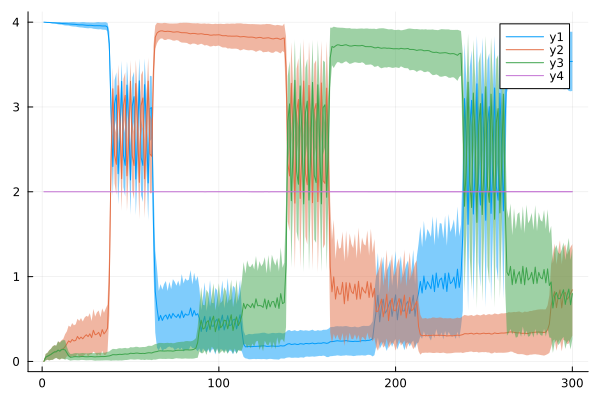

In [496]:
mv = [timestep_meanvar(enssol, n) for n in 1:size(enssol, 1)];
v = stack(last.(mv))'
m = stack(first.(mv))'
plot(m; ribbon = (sqrt.(v),sqrt.(v)))